In [65]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from raspi_import import raspi_import

# Forberedelse 2.1

### Regner ut tidsforskjell

In [66]:
def finn_forsinkelse(x, y, fs):
    x = x - np.mean(x)
    y = y - np.mean(y)

    r_xy = np.correlate(x, y, mode='full')
    lags = np.arange(-len(x)+1, len(x))
    sample_max = lags[np.argmax(np.abs(r_xy))]

    delta_t = sample_max / fs
    return sample_max, delta_t

### Vinkel utregning

In [67]:
def vinkel_med_tid(t_31,t_21,t_32):
    x = (t_31 - t_21 + 2*t_32)
    if x < 0:
        thetha = np.arctan2(np.sqrt(3) * (t_31 + t_21) , x ) + np.pi
    if x == 0:
        thetha = np.pi/2
    else:
        thetha = np.arctan2(np.sqrt(3) * (t_31 + t_21) , (t_31 - t_21 + 2*t_32) )
    return thetha  

def vinkel_med_samples(n_31,n_21,n_32):
    x = (n_31 - n_21 + 2*n_32)
    if x < 0:
        thetha = np.arctan2(np.sqrt(3) * (n_31 + n_21) , x ) + np.pi
    if x == 0:
        thetha = np.pi/2
    else: 
        thetha = np.arctan2(np.sqrt(3) * (n_31 + n_21) , x )
    return thetha



### Converter

In [68]:
C = 3.3
def converter(data): 
    resulution = 2**12
    Vconv = (C/resulution * data)
    return Vconv

Forsøk på vinkel utregning

Forsinkelse mellom mikrofon 3 og mikrofon 1: 0.000096 s, 3 samples
Forsinkelse mellom mikrofon 2 og mikrofon 1: 0.000000 s, 0 samples
Forsinkelse mellom mikrofon 3 og mikrofon 2: 0.000064 s, 2 samples

Vinkel beregnet med tid: 36.59 grader
Vinkel beregnet med samples: 36.59 grader


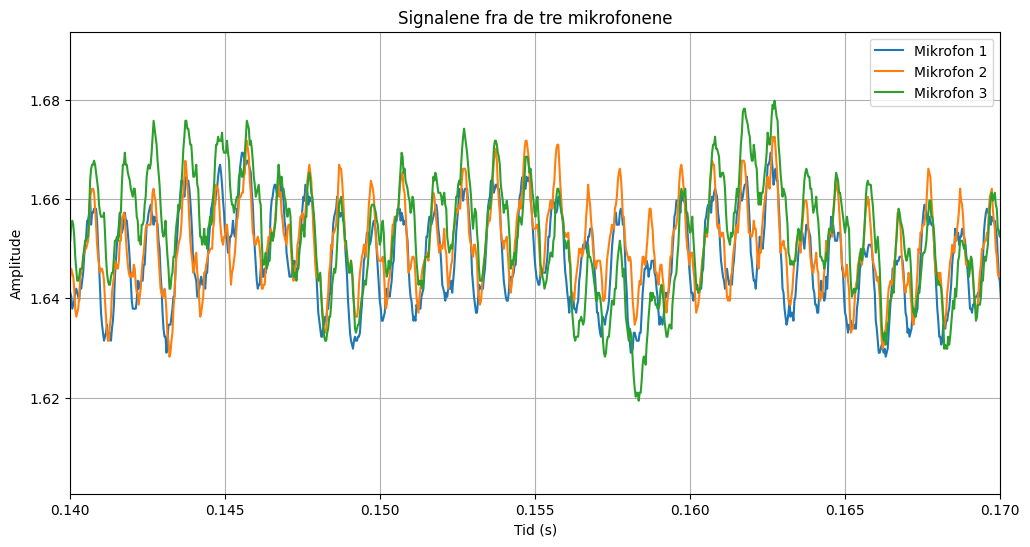

In [69]:
channels = 3
sample_period, data = raspi_import(f'Målinger/Akustikk_Sinus-90.bin', channels)
time_axis = np.arange(data.shape[0]) * sample_period

n = 3
M1 = data[n:, 0]
M2 = data[n:, 1]
M3 = data[n:, 2]
time_axis = time_axis[n:]

n_31, t_31 = finn_forsinkelse(M3, M1, 1/sample_period)
n_21, t_21 = finn_forsinkelse(M2, M1, 1/sample_period)
n_32, t_32 = finn_forsinkelse(M3, M2, 1/sample_period)

theta = vinkel_med_tid(t_31, t_21, t_32)
theta_samples = vinkel_med_samples(n_31, n_21, n_32)

print(f"Forsinkelse mellom mikrofon 3 og mikrofon 1: {t_31:.6f} s, {n_31} samples")
print(f"Forsinkelse mellom mikrofon 2 og mikrofon 1: {t_21:.6f} s, {n_21} samples")
print(f"Forsinkelse mellom mikrofon 3 og mikrofon 2: {t_32:.6f} s, {n_32} samples\n")
print(f"Vinkel beregnet med tid: {np.degrees(theta):.2f} grader")
print(f"Vinkel beregnet med samples: {np.degrees(theta_samples):.2f} grader")
plt.figure(figsize=(12, 6))
plt.plot(time_axis, converter(M1), label='Mikrofon 1')
plt.plot(time_axis, converter(M2), label='Mikrofon 2')
plt.plot(time_axis, converter(M3), label='Mikrofon 3')
plt.xlabel('Tid (s)')
plt.xlim(0.14, 0.17)
plt.ylabel('Amplitude')
plt.title('Signalene fra de tre mikrofonene')
plt.legend()
plt.grid()
plt.show()



### FFT

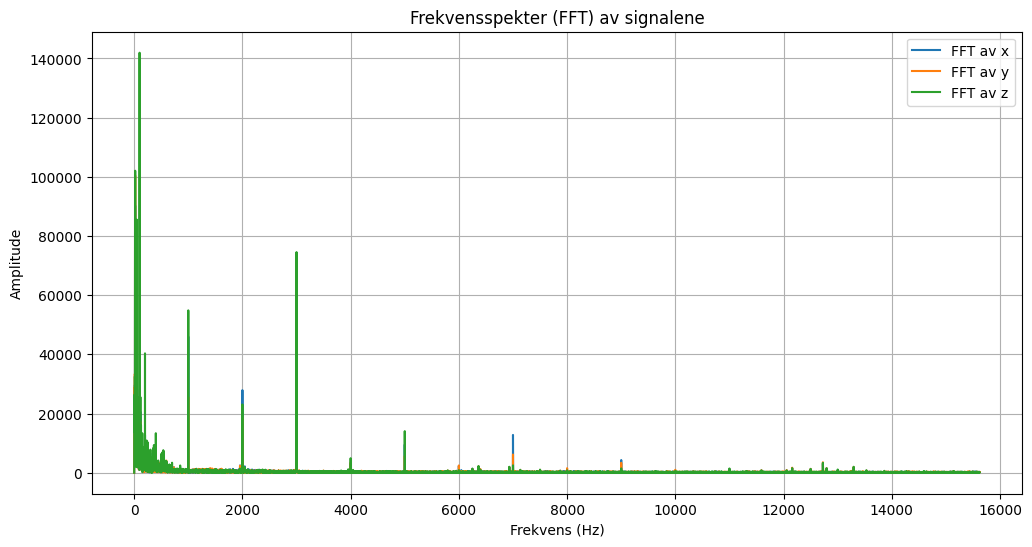

In [70]:

# Beregn FFT for x, y og z
N = len(x)  # Antall prøver
freq = np.fft.fftfreq(N, d=sample_period)  # Frekvensaksen
fft_x = np.fft.fft(x-x.mean())  # Fjern DC-komponenten før FFT
fft_y = np.fft.fft(y-y.mean())
fft_z = np.fft.fft(z-z.mean())

# Ta absoluttverdien for å få størrelsen på frekvenskomponentene
magnitude_x = np.abs(fft_x)
magnitude_y = np.abs(fft_y)
magnitude_z = np.abs(fft_z)

# Plot FFT-resultatene
plt.figure(figsize=(12, 6))
plt.plot(freq[:N // 2], magnitude_x[:N // 2], label='FFT av x')
plt.plot(freq[:N // 2], magnitude_y[:N // 2], label='FFT av y')
plt.plot(freq[:N // 2], magnitude_z[:N // 2], label='FFT av z')
plt.xlabel('Frekvens (Hz)')
plt.ylabel('Amplitude')
plt.title('Frekvensspekter (FFT) av signalene')
plt.legend()
plt.grid()
plt.show()


## 5 Like målinger

In [72]:
channels = 3
Målinger = []
for i in range(1, 6):
    sample_period, data = raspi_import(f'Målinger/Akustikk_SV{i}.bin', channels)
    time_axis = np.arange(data.shape[0]) * sample_period

    n = 3
    x = data[n:, 0]
    y = data[n:, 1]
    z = data[n:, 2]
    time_axis = time_axis[n:]
    
    n_31, t_31 = finn_forsinkelse(M3, M1, 1/sample_period)
    n_21, t_21 = finn_forsinkelse(M2, M1, 1/sample_period)
    n_32, t_32 = finn_forsinkelse(M3, M2, 1/sample_period)

    theta = vinkel_med_tid(t_31, t_21, t_32)
    theta_samples = vinkel_med_samples(n_31, n_21, n_32)

    Målinger.append((theta))
    print(f"Måling {i}:")
    print(f"Vinkel beregnet med tid: {np.degrees(theta):.2f} grader")
    print(f"Vinkel beregnet med samples: {np.degrees(theta_samples):.2f} grader\n")


std = np.std(Målinger)
print(f"Standardavvik for de 5 målingene: {np.degrees(std):.2f} grader")


Måling 1:
Vinkel beregnet med tid: 36.59 grader
Vinkel beregnet med samples: 36.59 grader

Måling 2:
Vinkel beregnet med tid: 36.59 grader
Vinkel beregnet med samples: 36.59 grader

Måling 3:
Vinkel beregnet med tid: 36.59 grader
Vinkel beregnet med samples: 36.59 grader

Måling 4:
Vinkel beregnet med tid: 36.59 grader
Vinkel beregnet med samples: 36.59 grader

Måling 5:
Vinkel beregnet med tid: 36.59 grader
Vinkel beregnet med samples: 36.59 grader

Standardavvik for de 5 målingene: 0.00 grader
